In [1]:
import os
import torch
from torch.utils.data import Dataset 
import pandas as pd
import cv2

class FaceMaskDataset(Dataset):
  """
  Facemask Dataset accessor 
  Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
  """
  def __init__(self, df, transform=None):
    """
    Initialize a Face Mask Dataset
    
    Params
    _________
    df: dataframe containing facemask images and labels
    transform: transformations to apply to images in dataset
    """
    self.facemask_df = df
    self.transform = transform

  def __len__(self):
    """Return the length of the dataset"""
    return len(self.facemask_df.index)

  def __getitem__(self, idx):
    """Return the <idx>'th sample from the dataset."""
    example = self.facemask_df.iloc[idx]
    img = self.transform(example['image']) if self.transform else example['image']
    sample = (img, example['label'])
    return sample

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class FaceMaskNetLowRes(nn.Module):
  """
  A model to detect facemasks in low resolution images
  References:
  (CNN) https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
  (Relu) https://www.superdatascience.com/blogs/convolutional-neural-networks-cnn-step-1b-relu-layer/
  (Calculating output channels) https://deeplizard.com/learn/video/cin4YcGBh3Q
  """

  def __init__(self):
    """
    Initialize a CNN model to detect facemasks in low resolution
    images
    """
    super().__init__()
    
    # 1st convolutional layer
    self.conv1 = nn.Conv2d(in_channels=1, 
                           out_channels=32, 
                           kernel_size=3, 
                           stride=1,
                           padding=(1,1))
    # 2nd convolutional layer
    self.conv2 = nn.Conv2d(in_channels=32, 
                           out_channels=64, 
                           kernel_size=3, 
                           stride=1,
                           padding=(1,1))

    # Pooling layer
    # Max pooling -> take largest value in local 2x2 pooling window
    self.pool = nn.MaxPool2d(kernel_size=2)


    # Fully connected layer
    self.fc1 = nn.Linear(in_features=4*4*64, out_features=64)

    # Output softmax layer
    self.softmax_layer = nn.Linear(in_features=64, out_features=2)
  
  def forward(self, X):
    """
    Execute the forward pass of image <X> through the CNN model and 
    return whether individual in image <X> is wearing a facemask or not
    
    Params
    _________
    X: an input image to the CNN model
    """
    # First layer of CNN 
    # (1) pass through first convolutional layer
    # (2) pass through Rectified Linear Unit -> introduce non linearity in image 
    #     after linearity caused by convolution step
    # (3) pass through pooling layer -> dimensionality reduction/noise removal
    X = self.pool(F.relu(self.conv1(X)))

    # Second layer of CNN
    # apply (1), (2) and (3)
    X = self.pool(F.relu(self.conv2(X)))

    # Flatten layer
    X = X.view(-1, 4*4*64)

    # pass flattened input through first fully connected layer
    X = F.relu(self.fc1(X))

    # pass through last layer (softmax layer)
    # rescale input to output -> No mask / mask
    X = self.softmax_layer(X)

    return F.softmax(X, dim=1)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [101]:
ROOT_DIR = "/content/drive/MyDrive/face_mask_detect"
DATASET_DIR = ROOT_DIR + "/dataset"
MASK_DIR = DATASET_DIR + "/with_mask"
NO_MASK_DIR = DATASET_DIR + "/without_mask"

hyperparams = {"learning_rate": 0.001, 
               "num_epochs": 500, 
               "batch_size": 64}

In [9]:
def build_dataframe(df):
  """
  Build dataframe containing all masked images with a label of 1
  and all unmasked images with a label of 0.
  
  Params
  _________
  df: the dataframe of images and labels

  Returns
  _________
  df: the dataframe containing all images and corresponding labels in dataset
  """
  df = add_data(df, MASK_DIR, 1)
  df = add_data(df, NO_MASK_DIR, 0)
  return df
  

def add_data(df, path, label):
  """
  Add sample containing image and corresponding label to dataframe
  
  Params
  _________
  df: the dataframe of images and labels
  path: path of the image to add
  label: 1 for masked images, otherwise 0

  Returns
  _________
  df: updated dataframe containing image located at <path> and <label>
  """
  img_dir = path
  for img_filename in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_filename)
    img = cv2.imread(img_path)
    df = df.append({'image': img, 'label': label}, ignore_index=True)
    print(len(df.index))
  return df


# Build dataframe of dataset
facemask_df = pd.DataFrame()
if os.path.exists(ROOT_DIR + "/df.pickle"):
  facemask_df = pd.read_pickle(ROOT_DIR + "/df.pickle")
else:
  facemask_df = build_dataframe(facemask_df)
  facemask_df.to_pickle(ROOT_DIR + "/df.pickle")

In [102]:
# Prepare data into train, validation and test sets (70% 15% 15%)
# preserving label proportions
train_df, test_df = train_test_split(facemask_df, 
                                     test_size=0.3, 
                                     random_state=1, 
                                     shuffle=True, 
                                     stratify=facemask_df['label']) 
 
train_df, val_df = train_test_split(train_df, 
                                    test_size=0.15/0.7, 
                                    random_state=1, 
                                    shuffle=True, 
                                    stratify=train_df['label'])

In [103]:
t = transforms.Compose([transforms.ToPILImage(), 
                        transforms.Resize((16, 16)), 
                        transforms.Grayscale(),
                        transforms.ToTensor()])


In [104]:
# From train, validation, test dataframes create corresponding datasets applying
# necessary transformations.
train_dataset = FaceMaskDataset(train_df, transform=t)
val_dataset = FaceMaskDataset(val_df, transform=t)
test_dataset = FaceMaskDataset(test_df, transform=t)

In [105]:
# Load Data
# Reference: https://www.journaldev.com/36576/pytorch-dataloader#:~:text=PyTorch%20offers%20a%20solution%20for,utils.

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=hyperparams["batch_size"], 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                          batch_size=hyperparams["batch_size"], 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=hyperparams["batch_size"], 
                          shuffle=True)

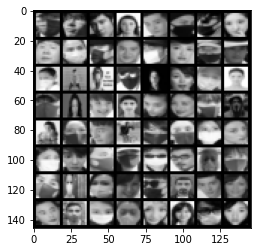

In [106]:
def show_batch(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

batch_iter = iter(train_loader)
batch_images, batch_labels = batch_iter.next()
show_batch(torchvision.utils.make_grid(batch_images))

In [107]:
# init GPU if available
if torch.cuda.is_available():
  device = torch.device('cuda')
  print("using GPU")
else: 
  device = torch.device('cpu')
# device = 'cpu'

using GPU


In [108]:
# define Model
model = FaceMaskNetLowRes()
model.to(device)

# define loss and weight update mechanism for model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])

In [109]:
def train(model, criterion, optimizer, loader):
  """
  Train the model by optimizing the loss function <criterion> 
  using the <optimizer> on the train dataset
  
  Params
  _________
  model: the model to train
  criterion: the loss function to optimize
  optimizer: mechanism to optimize model weights 
  loader: train dataset

  Returns
  _________
  accuracy: average epoch train accuracy
  loss: average epoch train loss
  """
  # Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
  n_correct = 0
  n_total = 0
  losses = []
  accs = []
  model.train()
  for batch_idx, (images, targets) in enumerate(loader):
    images = images.to(device)
    targets = torch.tensor(targets, dtype=torch.long).to(device)

    # zero out gradients (do not want accumulation from backward passes)
    optimizer.zero_grad()

    # forward pass
    preds = model(images)
    
    # calculate loss
    loss = criterion(preds, targets)
    losses.append(loss.item())

    # backpropagation 
    loss.backward()

    # update model params
    optimizer.step()
    
    # compute batch accuracy
    _, res = preds.max(1)
    n_correct += (res == targets).sum()
    n_total += res.size(0)
    accs.append(n_correct/n_total)

  print("Epoch {} -> Training Accuracy: {} | Training Loss: {}".format(
      epoch + 1, sum(accs)/len(accs), sum(losses)/len(losses)))
  return sum(accs)/len(accs), sum(losses)/len(losses)

In [110]:
def validation(model, criterion, optimizer, loader):
  """
  Set model to evaluation mode and calculate validation accuracies
  and losses for one epoch
  
  Params
  _________
  model: the trained model at current epoch
  criterion: the loss function to optimize
  optimizer: mechanism to optimize model weights 
  loader: validation dataset

  Returns
  _________
  accuracy: average epoch validation accuracy
  loss: average epoch validation loss
  """
  n_correct = 0
  n_total = 0
  losses = []
  accs = []
  model.eval()
  with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(val_loader):
      images = images.to(device)
      targets = torch.tensor(targets, dtype=torch.long).to(device)

      # predictions
      preds = model(images)

      # evaluate loss
      loss = criterion(preds, targets)
      losses.append(loss.item())

      # evaluate accuracy of predictions
      _, res = preds.max(1)
      n_correct += (res == targets).sum()
      n_total += res.size(0)

      accs.append(n_correct/n_total)

  print("Epoch:{} -> Validation Accuracy: {} |  Validaton Loss: {}".format(
      epoch+1, sum(accs)/len(accs), sum(losses)/len(losses)))
  return sum(accs)/len(accs), sum(losses)/len(losses)

**Low Resolution Training & Testing**

In [111]:
# training loop
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epochs = []
for epoch in range(hyperparams["num_epochs"]):
  train_acc, train_loss = train(model, criterion, optimizer, train_loader)
  val_acc, val_loss = validation(model, criterion, optimizer, val_loader)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accs.append(train_acc)
  val_accs.append(val_acc)
  epochs.append(epoch+1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 -> Training Accuracy: 0.5426636338233948 | Training Loss: 0.6743380644104697
Epoch:1 -> Validation Accuracy: 0.6313468813896179 |  Validaton Loss: 0.6315843529171414
Epoch 2 -> Training Accuracy: 0.7241185903549194 | Training Loss: 0.5707019386869489
Epoch:2 -> Validation Accuracy: 0.7864367365837097 |  Validaton Loss: 0.5182390941513909
Epoch 3 -> Training Accuracy: 0.8129196166992188 | Training Loss: 0.5004639291402065
Epoch:3 -> Validation Accuracy: 0.8275410532951355 |  Validaton Loss: 0.48761534359720016
Epoch 4 -> Training Accuracy: 0.8257841467857361 | Training Loss: 0.48389130198594293
Epoch:4 -> Validation Accuracy: 0.8051503300666809 |  Validaton Loss: 0.4864608811007606
Epoch 5 -> Training Accuracy: 0.8539146780967712 | Training Loss: 0.46332093170194916
Epoch:5 -> Validation Accuracy: 0.7691438794136047 |  Validaton Loss: 0.518919352028105
Epoch 6 -> Training Accuracy: 0.8322290182113647 | Training Loss: 0.45493493929053797
Epoch:6 -> Validation Accuracy: 0.81966960

In [112]:
def model_analysis(epochs, train, val, label, title):
  plt.plot(epochs, train, label="Training")
  plt.xlabel("Epoch")
  plt.plot(epochs, val, label="Validation")
  plt.ylabel(label)
  plt.title("Learning Rate: " + str(hyperparams["learning_rate"]) + " - " + title)
  plt.legend()
  plt.show()

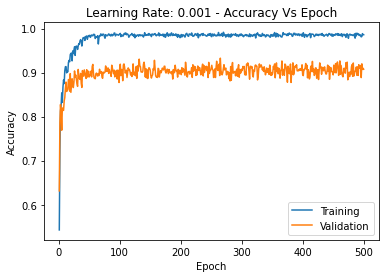

In [113]:
model_analysis(epochs, train_accs, val_accs, "Accuracy", "Accuracy Vs Epoch")

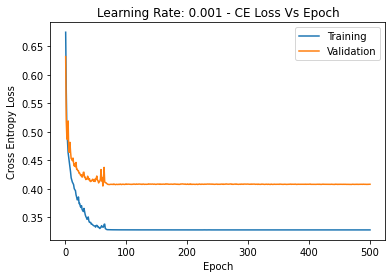

In [114]:
model_analysis(epochs, train_losses, val_losses, "Cross Entropy Loss", "CE Loss Vs Epoch")

In [117]:
# save model
torch.save(model.state_dict(), ROOT_DIR + "/low_res_model_final.pt")

In [134]:
model = FaceMaskNetLowRes()
model.load_state_dict(torch.load(ROOT_DIR + '/low_res_model.pt'))
model.to(device)
model.eval()

FaceMaskNetLowRes(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (softmax_layer): Linear(in_features=64, out_features=2, bias=True)
)

In [119]:
def get_accuracy(model, loader):
  """
  Return the model's perfomance accuracy on the dataset

  Params
  _________
  model: the trained model
  loader: dataset
  """
  n_correct = 0
  n_total = 0
  model.eval()
  with torch.no_grad():
    for images, targets in loader:
      images = images.to(device)
      targets = torch.tensor(targets, dtype=torch.long).to(device)

      # model predictions
      preds = model(images)

      # calculate model accuracy
      _, res = preds.max(1)
      n_correct += (res == targets).sum()
      n_total += res.size(0)
  return n_correct / n_total

In [116]:
train_acc = get_accuracy(model, train_loader)
test_acc = get_accuracy(model, test_loader)
val_acc = get_accuracy(model, val_loader)
test_acc = get_accuracy(model, test_loader)
print(f"Accuracy on train dataset is {train_acc}")
print(f"Accuracy on validation dataset is {val_acc}")
print(f"Accuracy on test dataset is {test_acc}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Accuracy on train dataset is 0.9852941036224365
Accuracy on validation dataset is 0.904347836971283
Accuracy on test dataset is 0.9017391204833984


In [135]:
def is_masked(model, face_img_path, show_plots=False):
  """
  Return 1 if pedestrian is wearing a mask, otherwise return 0

  Params
  _________
  model: the trained model
  face_img_path: the file path to the image for detection
  show_plots: display image transformation plots if True
  """
  face_img = cv2.cvtColor(cv2.imread(face_img_path), cv2.COLOR_BGR2RGB)

  if show_plots:
    plt.title("Original Image")
    plt.imshow(face_img)
    plt.show()

    plt.title("Resized Image (16x16)")
    plt.imshow(cv2.resize(face_img, dsize=(16, 16)))
    plt.show()

  # apply transformations to face image
  inp = t(face_img)
  if show_plots:
    plt.title("Transformed Image")
    plt.imshow(np.transpose(inp.numpy(), (1, 2, 0))[:, :, 0], "gray")
    plt.show()
  inp = inp.view(1, 1, 16, 16)
  inp = inp.to(device)

  # predict
  out = model(inp)
  pred = out.argmax()
  
  return "Wearing Mask" if pred.item() else "Not Wearing Mask"

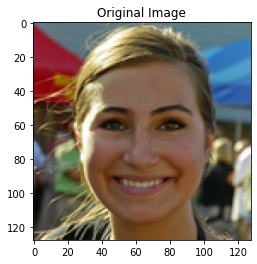

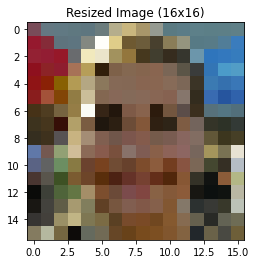

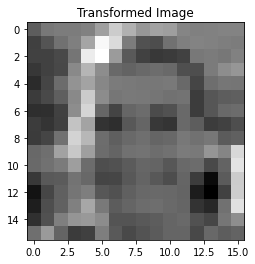

Not Wearing Mask


In [136]:
pred = is_masked(model, "/content/no_example.png", show_plots=True)
print(pred)

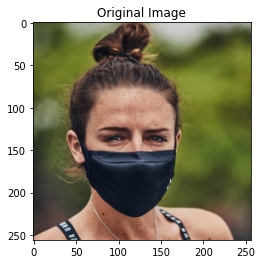

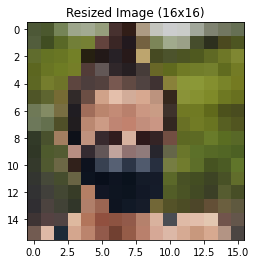

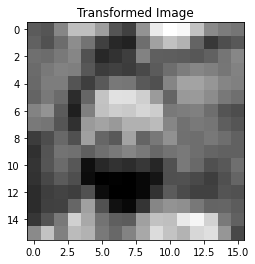

Wearing Mask


In [137]:
pred = is_masked(model, "/content/yes_example.jpg", show_plots=True)
print(pred)

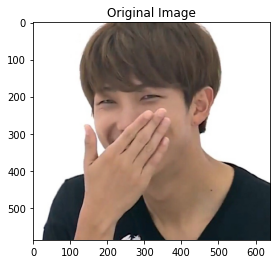

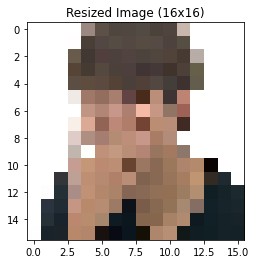

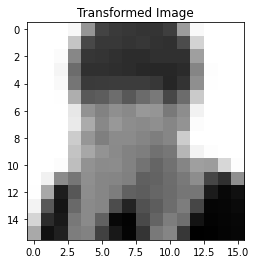

Not Wearing Mask


In [138]:
pred = is_masked(model, "/content/hand_on_mouth.jpg", show_plots=True)
print(pred)

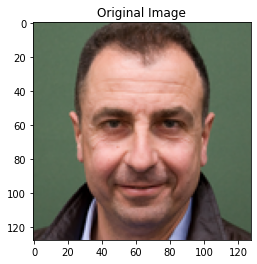

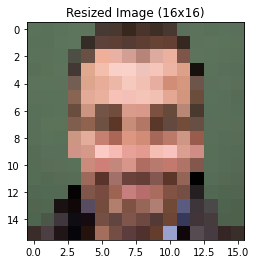

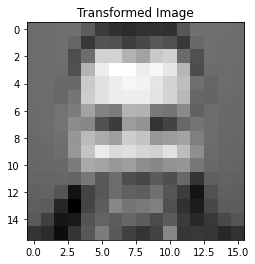

Not Wearing Mask


In [139]:
pred = is_masked(model, "/content/no2.png", show_plots=True)
print(pred)

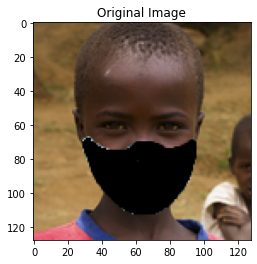

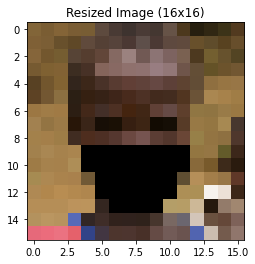

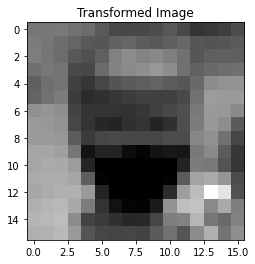

Wearing Mask


In [140]:
pred = is_masked(model, "/content/32008_masked.png", show_plots=True)
print(pred)

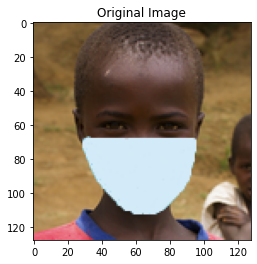

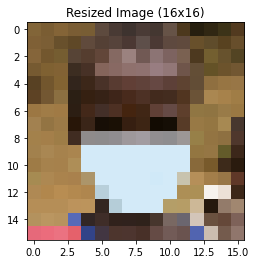

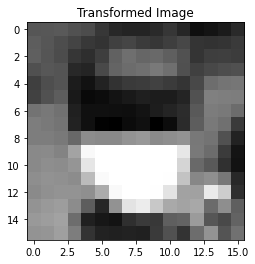

Wearing Mask


In [141]:
pred = is_masked(model, "/content/32008_bluemask2.png", show_plots=True)
print(pred)

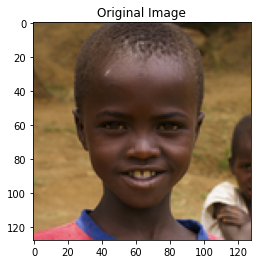

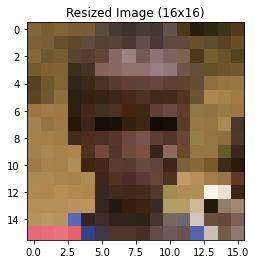

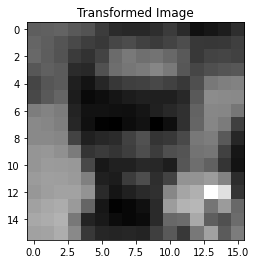

Wearing Mask


In [142]:
pred = is_masked(model, "/content/32008.png", show_plots=True)
print(pred)

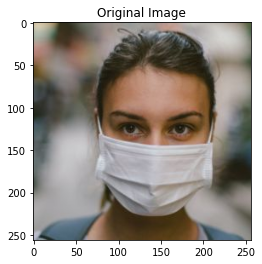

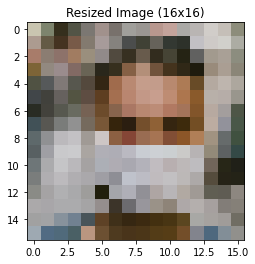

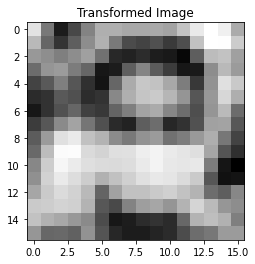

Wearing Mask


In [143]:
pred = is_masked(model, "/content/white_mask.jpg", show_plots=True)
print(pred)

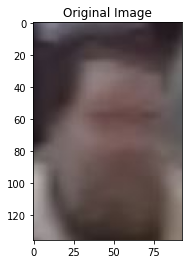

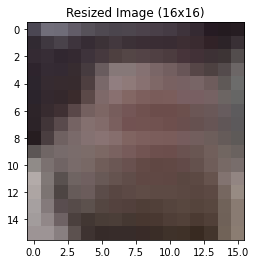

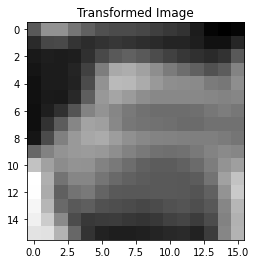

Not Wearing Mask


In [144]:
pred = is_masked(model, "/content/low_res_no.JPG", show_plots=True)
print(pred)

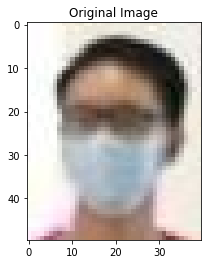

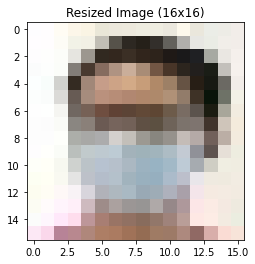

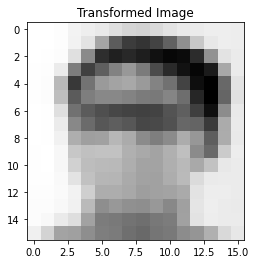

Wearing Mask


In [145]:
pred = is_masked(model, "/content/yes.JPG", show_plots=True)
print(pred)

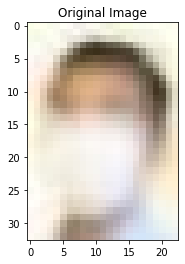

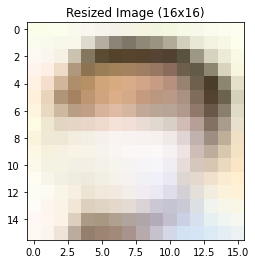

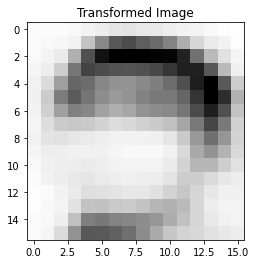

Wearing Mask


In [146]:
pred = is_masked(model, "/content/low_res_yes.JPG", show_plots=True)
print(pred)